In [2]:
pip install fastapi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.8 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from fastapi import FastAPI


In [7]:
pip install "uvicorn[standard]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.8/459.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.1 MB/s eta 0:00:00


In [8]:
import uvicorn

In [10]:
data= pd.read_csv("/content/creditcard.csv")
print("Dataset Shape:", data.shape)
print("Class Distribution:\n", data['Class'].value_counts(normalize=True))

Dataset Shape: (5974, 31)
Class Distribution:
 Class
0.0    0.999498
1.0    0.000502
Name: proportion, dtype: float64


In [11]:
X = data.drop('Class', axis=1)  # Features
y = data['Class']  # Target

In [12]:
scaler = StandardScaler()
X_scaled= scaler.fit_transform(X)

In [14]:
# Check for NaN values
print("NaN values in dataset:\n", data.isna().sum())
print("Dataset Shape:", data.shape)
print("Class Distribution:\n", data['Class'].value_counts(normalize=True))


NaN values in dataset:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64
Dataset Shape: (5974, 31)
Class Distribution:
 Class
0.0    0.999498
1.0    0.000502
Name: proportion, dtype: float64


In [15]:
data = data.dropna(subset=['Class'])
print("\nShape after dropping NaN in Class:", data.shape)



Shape after dropping NaN in Class: (5973, 31)


In [16]:
X = data.drop('Class', axis=1)
y = data['Class']

# Handle NaN in features (impute with mean for numerical features)
X = X.fillna(X.mean())

# Verify no NaN in y
if y.isna().sum() > 0:
    raise ValueError("NaN values still present in target 'y' after preprocessing!")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
fraud_count = y_train.sum()
print("\nNumber of fraud cases in y_train:", fraud_count)

# Step 3: Apply SMOTE with dynamic k_neighbors
if fraud_count < 6:
    k_neighbors = max(1, fraud_count - 1)  # Ensure k_neighbors <= fraud_count
    print(f"Adjusting k_neighbors to {k_neighbors} due to low fraud samples")
else:
    k_neighbors = 5  # Default value
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_scaled = StandardScaler().fit_transform(X_train)  # Scale before SMOTE
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)
print("\nAfter SMOTE, training class distribution:\n", pd.Series(y_train_sm).value_counts())

# Scale test data
scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)  # Re-scale SMOTE data
X_test_scaled = scaler.transform(X_test)



Number of fraud cases in y_train: 2.0
Adjusting k_neighbors to 1 due to low fraud samples

After SMOTE, training class distribution:
 Class
0.0    4776
1.0    4776
Name: count, dtype: int64


In [20]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
model.fit(X_train_sm, y_train_sm)


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [21]:
joblib.dump(model, 'fraud_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [22]:
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))



Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1194
         1.0       0.00      0.00      0.00         1

    accuracy                           1.00      1195
   macro avg       0.50      0.50      0.50      1195
weighted avg       1.00      1.00      1.00      1195

ROC-AUC Score: 0.48408710217755446


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


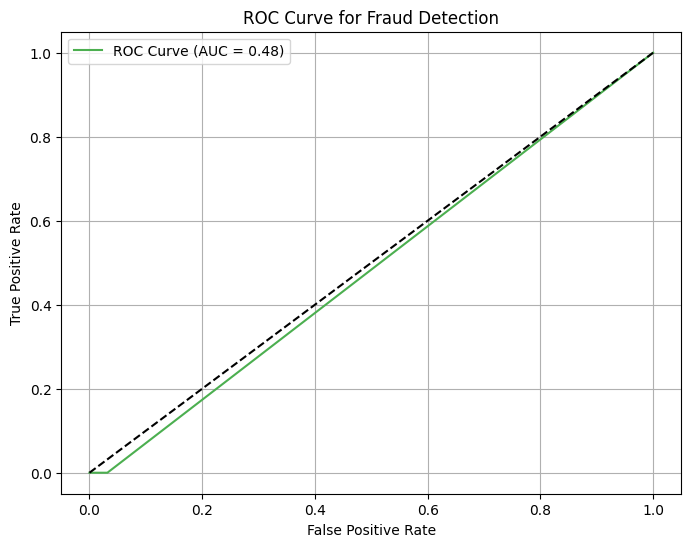

In [24]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})', color='#4CAF50')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Fraud Detection')
plt.legend()
plt.grid(True)
plt.savefig('roc_curve.png')
